In [2]:
import keras as keras
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report

#import tensorflow_addons as tfa

Cargamos los datos tanto de entrada (train y test) y sus respectivos labels.

In [3]:

(x_ps_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
def EDA_plothist(data,histname):
  unique, counts = np.unique(data, return_counts=True)
  counts = np.bincount(data)
  fig, ax = plt.subplots(figsize=(10,5))
  ax.bar(range(10), counts, width=0.8, align='center')
  ax.set(xticks=range(10), xlim=[-1, 10], title=histname)
  plt.show()

In [5]:


#plt.imshow(x_train[1,...], cmap='gray')
#print(y_train.shape,x_train.shape)

# Exploratory Data Analisys
Observaremos sobre los datos a procesar, para caracterizar el problema a resolver.


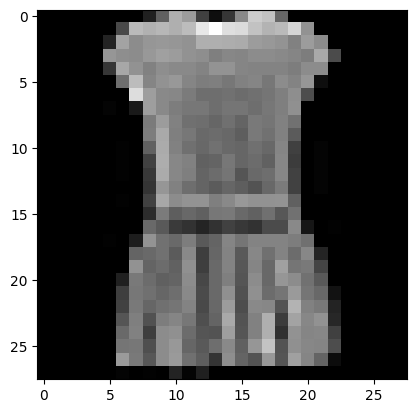

In [6]:
plt.imshow(x_ps_train[3,...], cmap="gray")

El dataset cuenta con 70.000 imagenes de 28x28px que corresponden a imagenes en un solo canal de 10 categorias de prendas de ropa diferentes. A continuacion mostramos un ejemplo de cada clase:

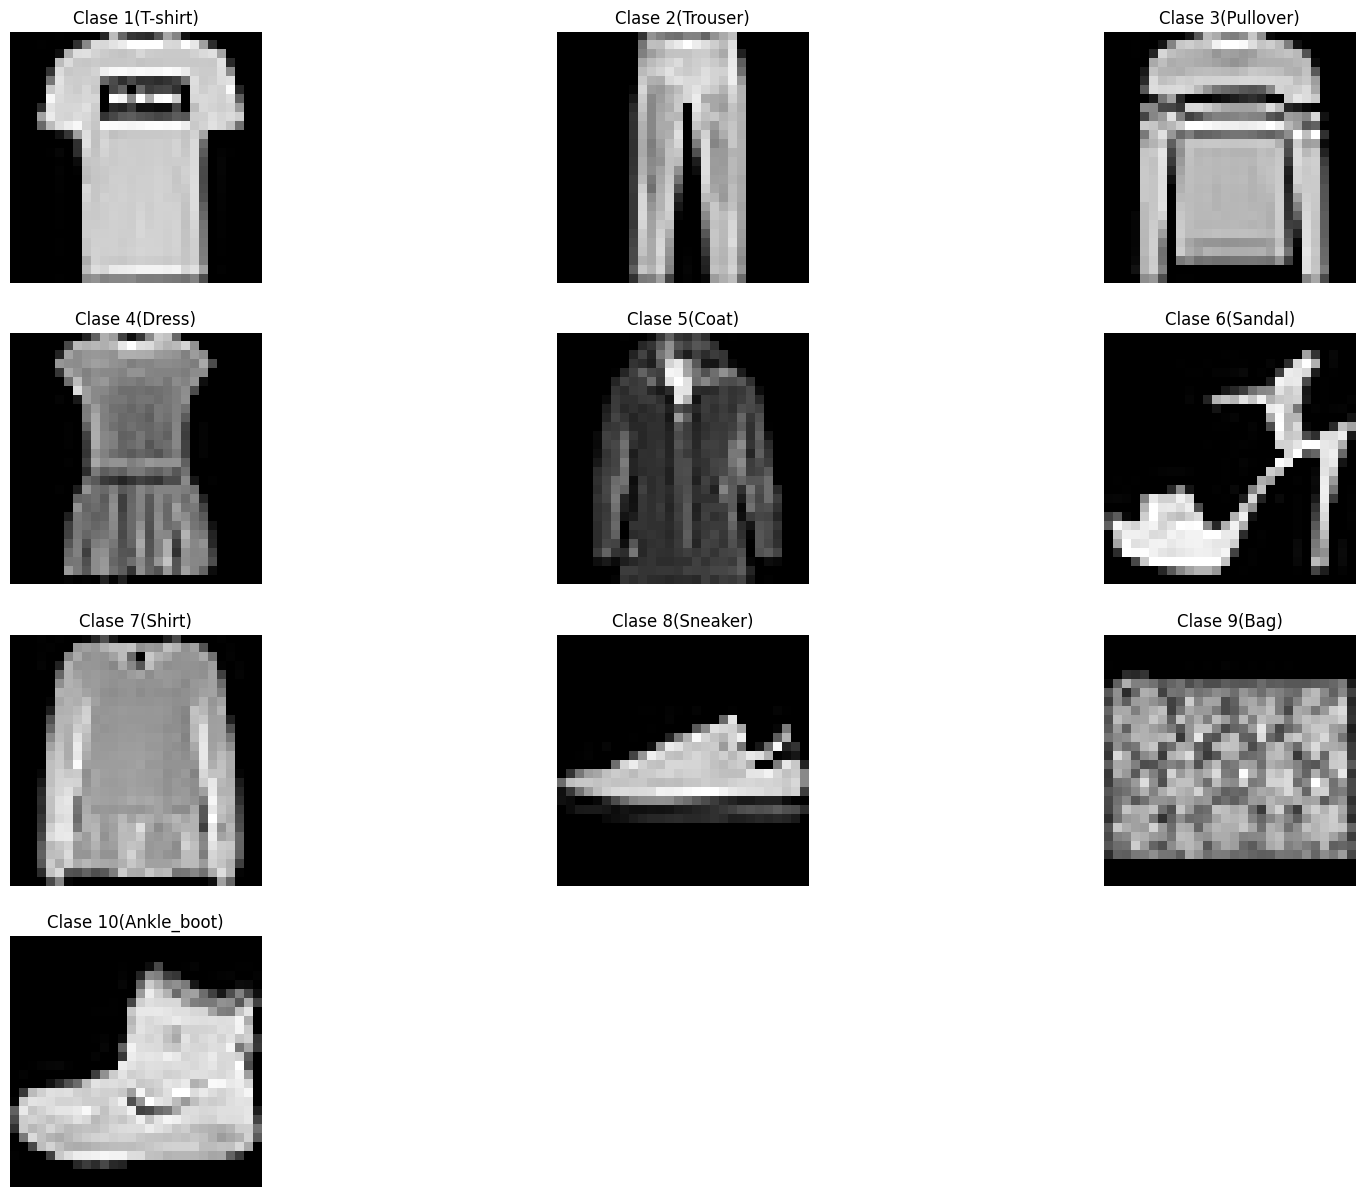

In [7]:
#Indices a ejemplos

ejs=[1, 16, 5, 3, 19, 9, 18, 6, 23, 0]
prendas=[]
classes_fashion={
1: "T-shirt",
2: "Trouser",
3: "Pullover",
4: "Dress",
5: "Coat",
6: "Sandal",
7: "Shirt",
8: "Sneaker",
9: "Bag",
10: "Ankle_boot"}
# create figure
fig = plt.figure(figsize=(20, 15))
# setting values to rows and column variables
rows = 4
columns = 3
fig_counter=1
# Adds a subplot at the 1st position
for ej in ejs:
  fig.add_subplot(rows, columns, fig_counter)
  plt.imshow(x_ps_train[ej],cmap="gray")
  plt.axis('off')
  plt.title("Clase "+str(fig_counter)+'('+classes_fashion[fig_counter]+')')
  fig_counter=fig_counter+1



##Analizamos la distribucion de estos datos

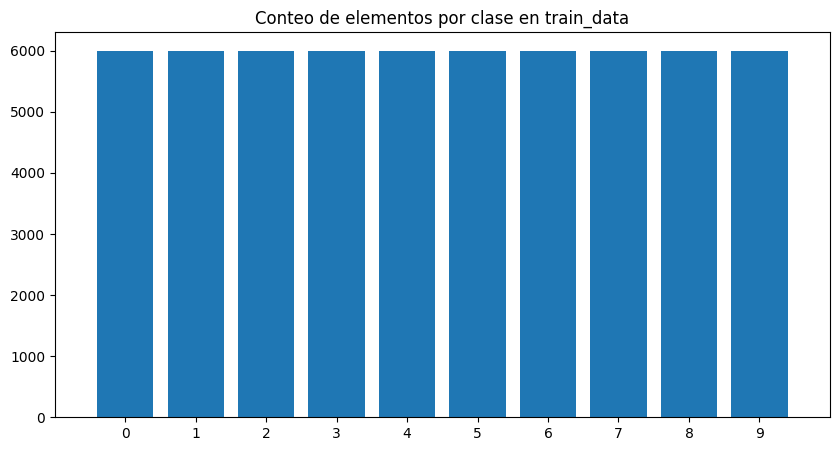

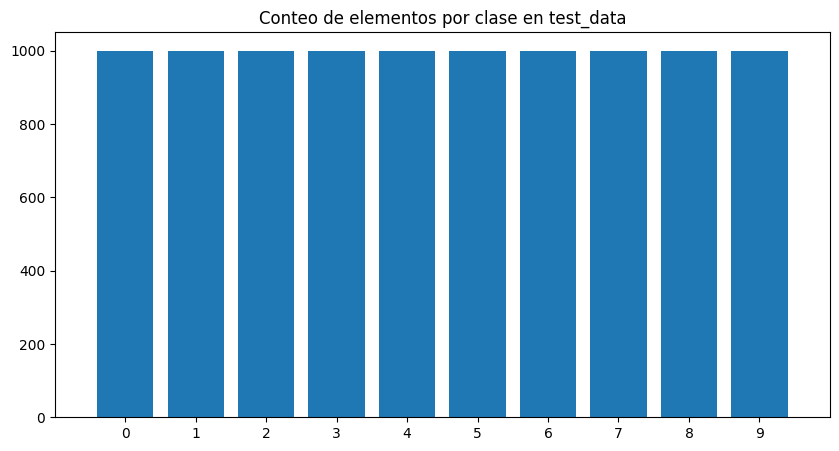

In [8]:
# counts, bins = np.histogram(y_train)
# print(counts,"+  ",bins)
# plt.xticks(range(11));
# plt.hist(bins, bins=10, weights=counts, histtype='bar', align='mid')
EDA_plothist(y_train,"Conteo de elementos por clase en train_data")
EDA_plothist(y_test,"Conteo de elementos por clase en test_data")


#Procesamiento de datos:
1)One hot encoding de las clases:

In [9]:

y_sparse_train = np.zeros([60000,10])
y_sparse_test = np.zeros([10000,10])
for idx in range(60000):
    y_sparse_train[idx,y_train[idx]] = 1
for idx in range(10000):
    y_sparse_test[idx,y_test[idx]] = 1


2)Separo en train y validate, luego normalizo los datos:

In [10]:
print(x_ps_train.shape)



(60000, 28, 28)


(42000, 28, 28)
(18000, 28, 28)
(42000, 10)
(18000, 10)


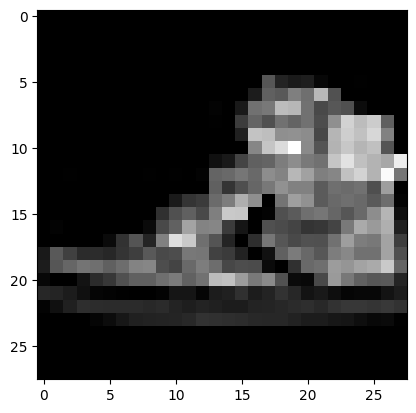

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


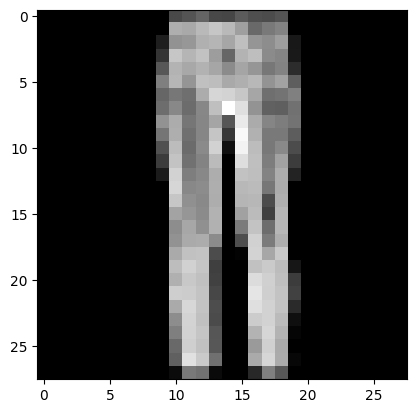

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
x_train, x_validate, y_train, y_validate = train_test_split(x_ps_train, y_sparse_train, test_size=0.3)
#x_train = x_train/255
#x_validate = x_validate/255
#
print(x_train.shape)
print(x_validate.shape)
print(y_train.shape)
print(y_validate.shape)
plt.imshow(x_train[0,:,:], cmap="gray")
plt.show()
print(y_train[0,:])
plt.imshow(x_validate[0,:,:], cmap="gray")
plt.show()
print(y_validate[0,:])


Hasta aqui preprocesamiento

In [12]:
from keras.models import Sequential
import keras.layers
from keras.layers import Dense, Flatten
from keras.optimizers import SGD, Adam, adagrad




#Defino mis funciones de exploración
Pretendo loopear a traves de las mismas, creando a partir de ellas diversos modelos afín de compararlos.

In [13]:
#Funcion que crea un modelo basado en un clasificador MLP.
#Guardado de metricas y early stopping activados, modificable para realizar pruebas
# Parametros: Optimizador (string preseteado o callback), metodo de regularizacion de pesos y de inicializacion de pesos. Además se especidifca si se requiere o no de batch normalization
# nlayers=cantidad de capas intermedias, layer_act=[relu,softmax],layer_desity
def new_model_softmax (optimizador,kernreg,kerninit, layer_act, layer_density, dpout_layer=0,batch_normalization=False, nlayers=1):
  nClases = 10
  model_name = "Modelo con optimizacion "+optimizador+", Regularizacion kernel "+kernreg+" y kerninit "+kerninit
  #Early Stopping
  es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.1,
    patience=3,
    verbose=1,
    mode="max",
    baseline=60,
    restore_best_weights=True,
    start_from_epoch=2)
  #Callbacks para guardar datos
  mc = tf.keras.callbacks.ModelCheckpoint(model_name+'.h5', monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)
  model = Sequential()
  model.add(Flatten(input_shape=(28,28,1)))
  for i in range(nlayers):
    model.add(Dense(layer_density[i],layer_act[i]))
    if dpout_layer>0:
      model.add(tf.keras.layers.Dropout(rate=dpout_layer))
    if bool(batch_normalization):
      model.add(tf.keras.layers.BatchNormalization())

  model.add(Dense(nClases, activation="softmax",kernel_initializer=kerninit))
  #,kernel_regularizer=kernreg
  model.compile(loss= 'categorical_crossentropy', optimizer=optimizador,
                  metrics=["accuracy"])
  history = model.fit(x= x_train, y = y_train, validation_data=(x_validate, y_validate), batch_size = 32, epochs=200, callbacks=[es,mc])
  model.summary()
  val_los, val_acc = model.evaluate(x_test,y_sparse_test)
  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred, axis = 1)
  print(y_pred,y_test)
  classification_rep = classification_report(y_test,y_pred,output_dict=True)
  return (history,classification_rep,model_name)



#Funcion que plotea los graficos de accuracies y losses. Agrupa de a N modelos
def plot_compare(results_vector, models_perfig=4):
  model_count = len(results_vector)
  #Iteramos entre todos los modelos a.k.a resultados y agrupamos de a 4 por grafico.
  for i in range(model_count):
    plt.plot(results_vector[i][0].history['loss'], label="M "+str(i)+" train")#Plot de los
    plt.plot(results_vector[i][0].history['val_loss'],'--', label="M "+str(i)+" test")
    if (i+1)%models_perfig==0:
      plt.title('Losses vs Epoch')
      plt.legend(loc='upper right')
      plt.show()
    elif i+1==model_count:
      plt.title('Losses vs Epoch')
      plt.legend(loc='upper right')
      plt.show()


  for i in range(len(results_vector)):
    plt.plot(results_vector[i][0].history['accuracy'], label="M "+str(i)+" train")#Plot de los
    plt.plot(results_vector[i][0].history['val_accuracy'],'--' , label="M "+str(i)+" test")
    if (i+1)%4==0:
      plt.title('Accuracy vs Epoch')
      plt.legend(loc='lower right')
      plt.show()
    elif i+1==model_count:
      plt.title('Accuracy vs Epoch')
      plt.legend(loc='lower right')
      plt.show()

def plot_class_reports(results_vector):
  clases_dict=['0','1','2','3','4','5','6','7','8','9']
  metricas_dict=['precision','recall','f1-score','support']
  colores = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
  precision_vect= []
  recall_vect=[]
  f1_vect=[]
  nClases = 10
  axis_ID=0
  deca_count = 0
  x = np.arange(10)
  subplot_count = 3*((int(len(results_vector)/10))+1)
  fig, ax = plt.subplots(subplot_count,figsize=(25,15))
  print(len(results_vector))
  for j in range(len(results_vector)):
    if j>0 and (j%10)==0 :
      axis_ID = axis_ID + 3
      deca_count = deca_count + 10

    for i in range(nClases):
      precision_vect.append(results_vector[j][1][clases_dict[i]][metricas_dict[0]])
      recall_vect.append(results_vector[j][1][clases_dict[i]][metricas_dict[1]])
      f1_vect.append(results_vector[j][1][clases_dict[i]][metricas_dict[2]])
    ax[axis_ID].stem(x+(j-deca_count)*0.09, precision_vect[(j*10):(((j+1)*10))], label="M"+str(j),linefmt=colores[j-deca_count])
    ax[axis_ID].set(xlim=(0, 10), xticks=np.arange(0, 10),
      ylim=(0, 1.1), yticks=np.arange(0,1,0.1))
    ax[axis_ID+1].stem(x+(j-deca_count)*0.09, recall_vect[(j*10):(((j+1)*10))], label="M"+str(j),linefmt=colores[j-deca_count])
    ax[axis_ID+1].set(xlim=(0, 10), xticks=np.arange(0, 10),
      ylim=(0, 1.1), yticks=np.arange(0,1,0.1))
    ax[axis_ID+2].stem(x+(j-deca_count)*0.09, f1_vect[(j*10):(((j+1)*10))], label="M"+str(j),linefmt=colores[j-deca_count])
    ax[axis_ID+2].set(xlim=(0, 10), xticks=np.arange(0, 10),
      ylim=(0, 1.1), yticks=np.arange(0,1,0.1))

  for axcount in range(subplot_count):
    models_ids = int(axcount/3)*10
    title_start = metricas_dict[axcount%3]
    if axcount%3==0:
      ax[axcount].legend(loc='best')
    title=title_start+" modelos "+str(models_ids)+" al "+str(models_ids+10)
    ax[axcount].set_title( label = title , fontdict=None, loc='center', pad=0.8)
  plt.show()

#Funcion que extrae los mejores modelos en cada una de las métricas.
def print_best_models(results_vector):
  result_count = len(results_vector)

  acc_vect=[]
  valacc_vect=[]
  loss_vect=[]
  valloss_vect=[]
  for result in range(result_count):
    acc_vect.append(max(results_vector[:][result][0].history['accuracy']))
    valacc_vect.append(max(results_vector[:][result][0].history['val_accuracy']))
    loss_vect.append(max(results_vector[:][result][0].history['loss']))
    valloss_vect.append(max(results_vector[:][result][0].history['val_loss']))

  max_accuracy_index = acc_vect.index(max(acc_vect))
  max_valaccuracy_index = valacc_vect.index(max(valacc_vect))
  min_loss_index = loss_vect.index(min(loss_vect))
  min_valloss_index = valloss_vect.index(min(valloss_vect))
  print("El modelo con mejor accuracy de train es el: M",max_accuracy_index," (",results_vector[max_accuracy_index][2],") ----> Acc:",acc_vect[max_accuracy_index])
  print("El modelo con mejor accuracy de validacion es el: M",max_valaccuracy_index," (",results_vector[max_valaccuracy_index][2],") ----> ValAcc:",valacc_vect[max_valaccuracy_index])
  print("El modelo con mejor loss de train es el: M",min_loss_index,"(",results_vector[min_loss_index][2],") ----> Loss:",loss_vect[min_loss_index])
  print("El modelo con mejor loss de validacion es el: M",min_valloss_index,"(",results_vector[min_valloss_index][2],") ----> ValLoss:",valloss_vect[min_valloss_index])


##Modelo 0
Entrenamos un primer modelo. Ubicamos usaremos 3 capas ocultas con activacion relu y una sigmoidea para la capa de salida.

Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal
Epoch 1/200
1299/1313 [============================>.] - ETA: 0s - loss: 0.9406 - accuracy: 0.7729
Epoch 1: val_accuracy improved from -inf to 0.83767, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal.h5
1313/1313 [==============================] - 12s 5ms/step - loss: 0.9359 - accuracy: 0.7735 - val_loss: 0.4686 - val_accuracy: 0.8377
Epoch 2/200
1300/1313 [============================>.] - ETA: 0s - loss: 0.4613 - accuracy: 0.8358
Epoch 2: val_accuracy improved from 0.83767 to 0.85178, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal.h5
1313/1313 [==============================] - 6s 5ms/step - loss: 0.4616 - accuracy: 0.8357 - val_loss: 0.4042 - val_accuracy: 0.8518
Epoch 3/200
1300/1313 [============================>.] - ETA: 0s - loss: 0.4111 - accuracy: 0.8501
Epoch 3: val_accuracy improved from 0.85178 to 0.85767, savin

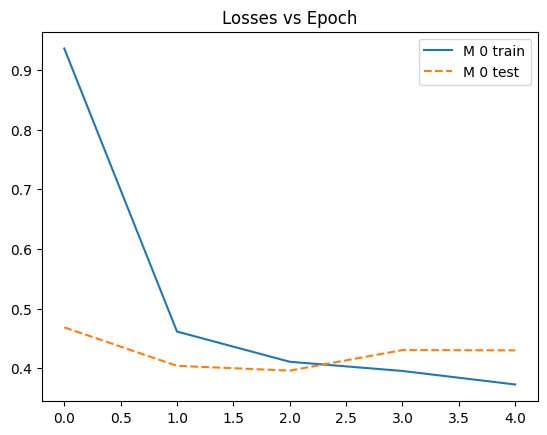

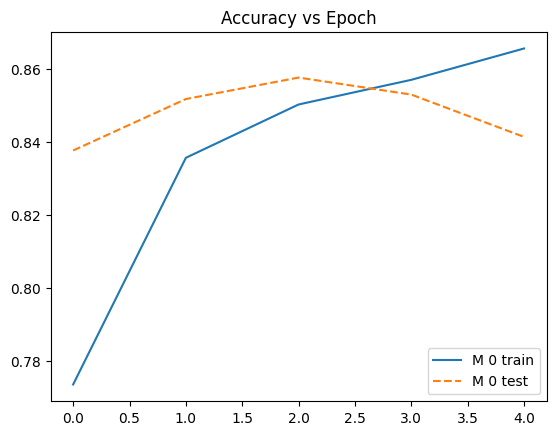

1


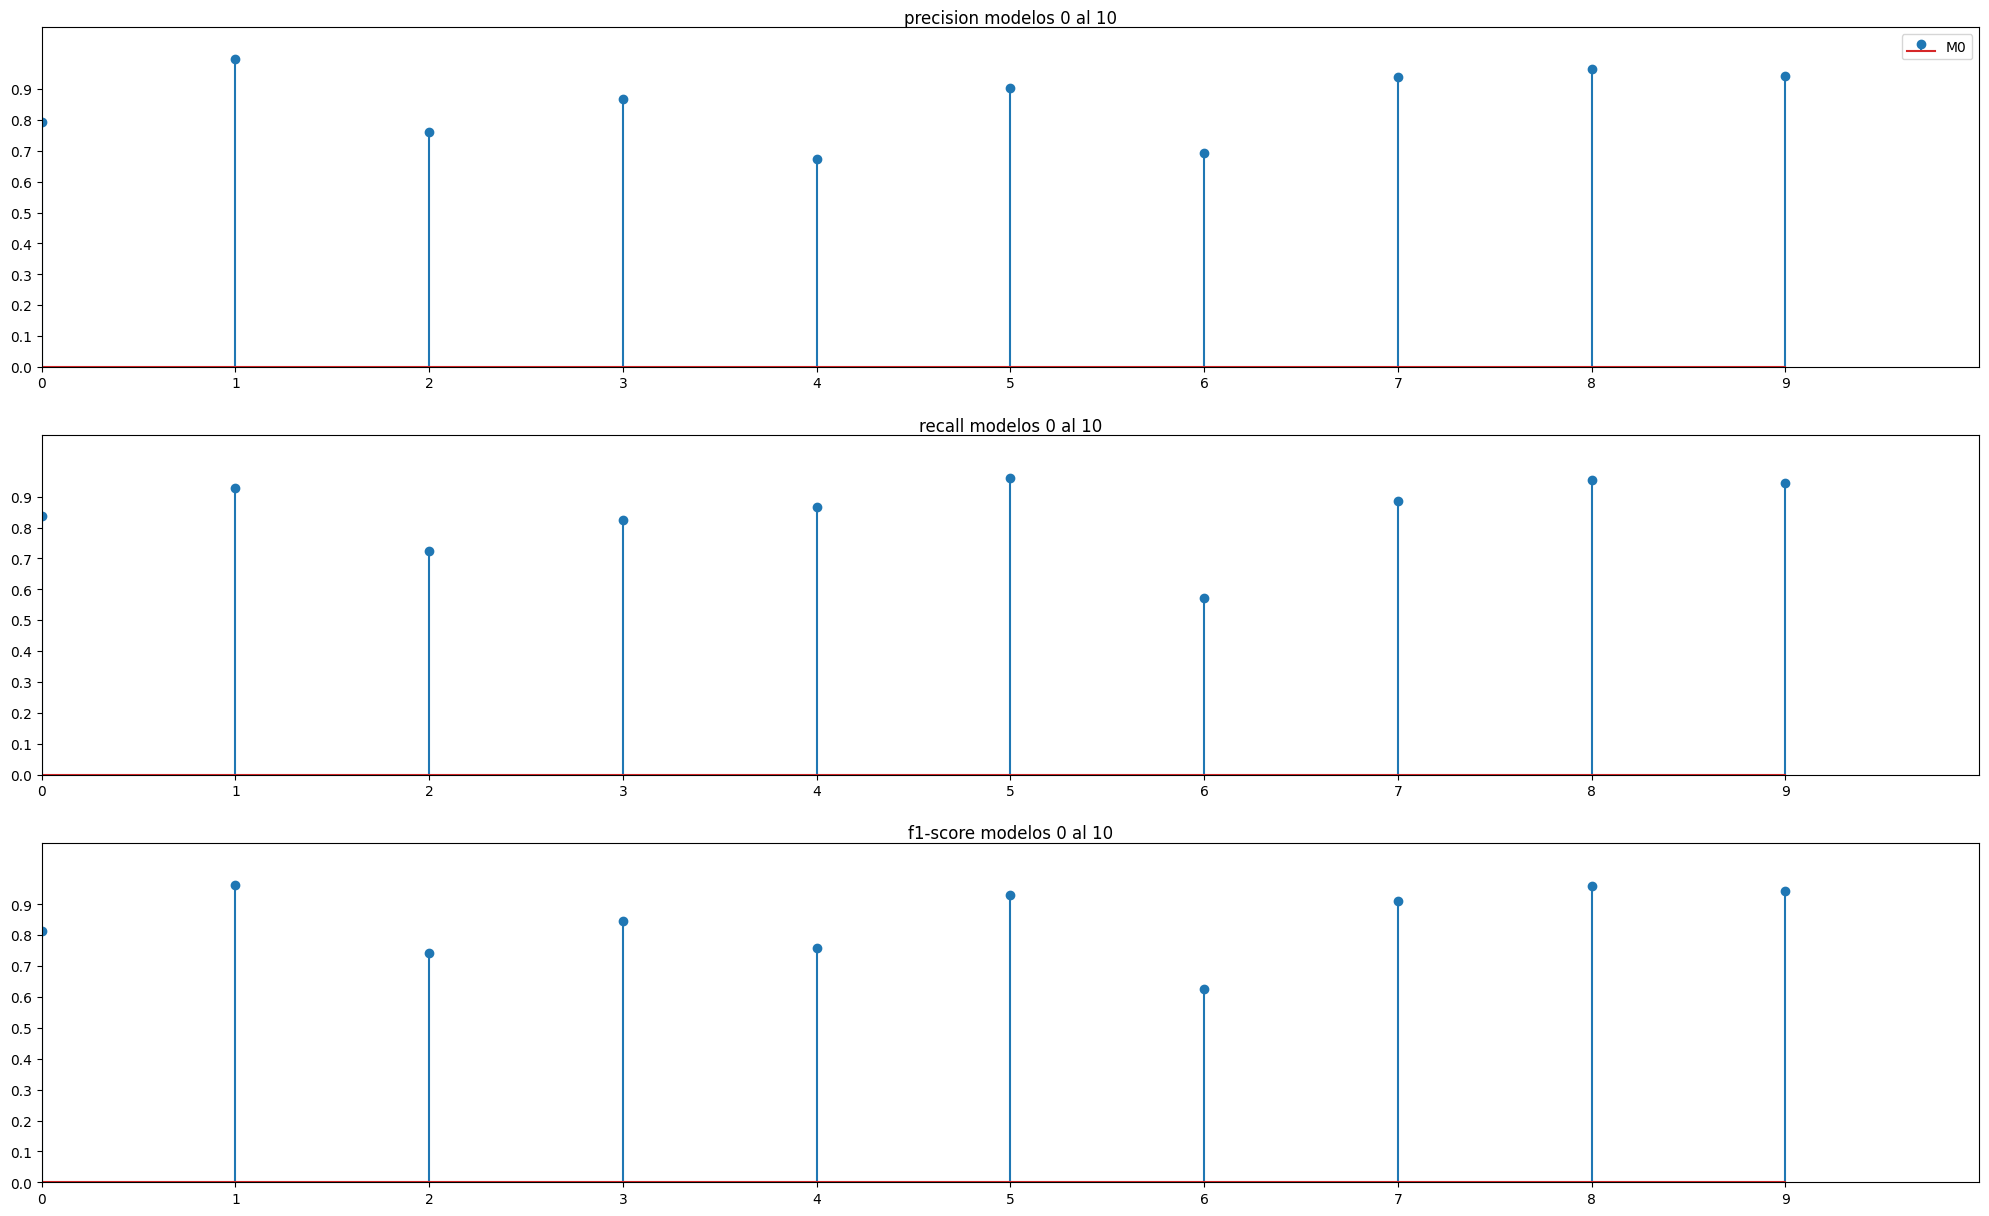

El modelo con mejor accuracy de train es el: M 0  ( Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal ) ----> Acc: 0.8656428456306458
El modelo con mejor accuracy de validacion es el: M 0  ( Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal ) ----> ValAcc: 0.8576666712760925
El modelo con mejor loss de train es el: M 0 ( Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal ) ----> Loss: 0.9359357357025146
El modelo con mejor loss de validacion es el: M 0 ( Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal ) ----> ValLoss: 0.46863991022109985


In [14]:
optimizador = 'Adam'
kernreg= 'l1_l2'
kerninit='normal'
n_layers=3
layer_act_list = ['relu','relu','relu','softmax']
layer_density_list  = [512,64,64]
#[25,100,25,50]
nlayers_list = ['1','1','2','2']
results_vector=list()
model_results_tuple = new_model_softmax(optimizador,kernreg,kerninit,nlayers=n_layers,layer_act=layer_act_list, layer_density=layer_density_list)
results_vector.append(model_results_tuple)
plot_compare(results_vector)
plot_class_reports(results_vector)

print_best_models(results_vector)

##Modelo 1

Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal
Epoch 1/200
1312/1313 [============================>.] - ETA: 0s - loss: 2.3030 - accuracy: 0.1001
Epoch 1: val_accuracy improved from -inf to 0.10006, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal.h5
1313/1313 [==============================] - 8s 5ms/step - loss: 2.3030 - accuracy: 0.1001 - val_loss: 2.3028 - val_accuracy: 0.1001
Epoch 2/200
1310/1313 [============================>.] - ETA: 0s - loss: 2.3029 - accuracy: 0.0996
Epoch 2: val_accuracy improved from 0.10006 to 0.10056, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal.h5
1313/1313 [==============================] - 8s 6ms/step - loss: 2.3029 - accuracy: 0.0995 - val_loss: 2.3027 - val_accuracy: 0.1006
Epoch 3/200
1308/1313 [============================>.] - ETA: 0s - loss: 2.3030 - accuracy: 0.0984
Epoch 3: val_accuracy did not improve from 0.10056
1313/1313 [

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


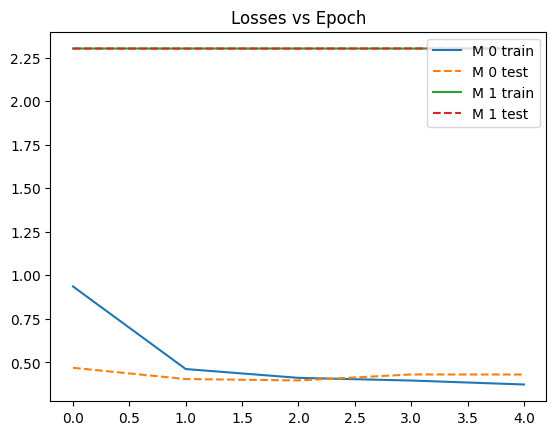

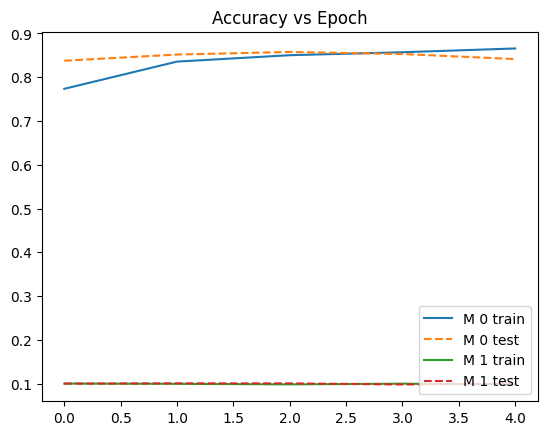

2


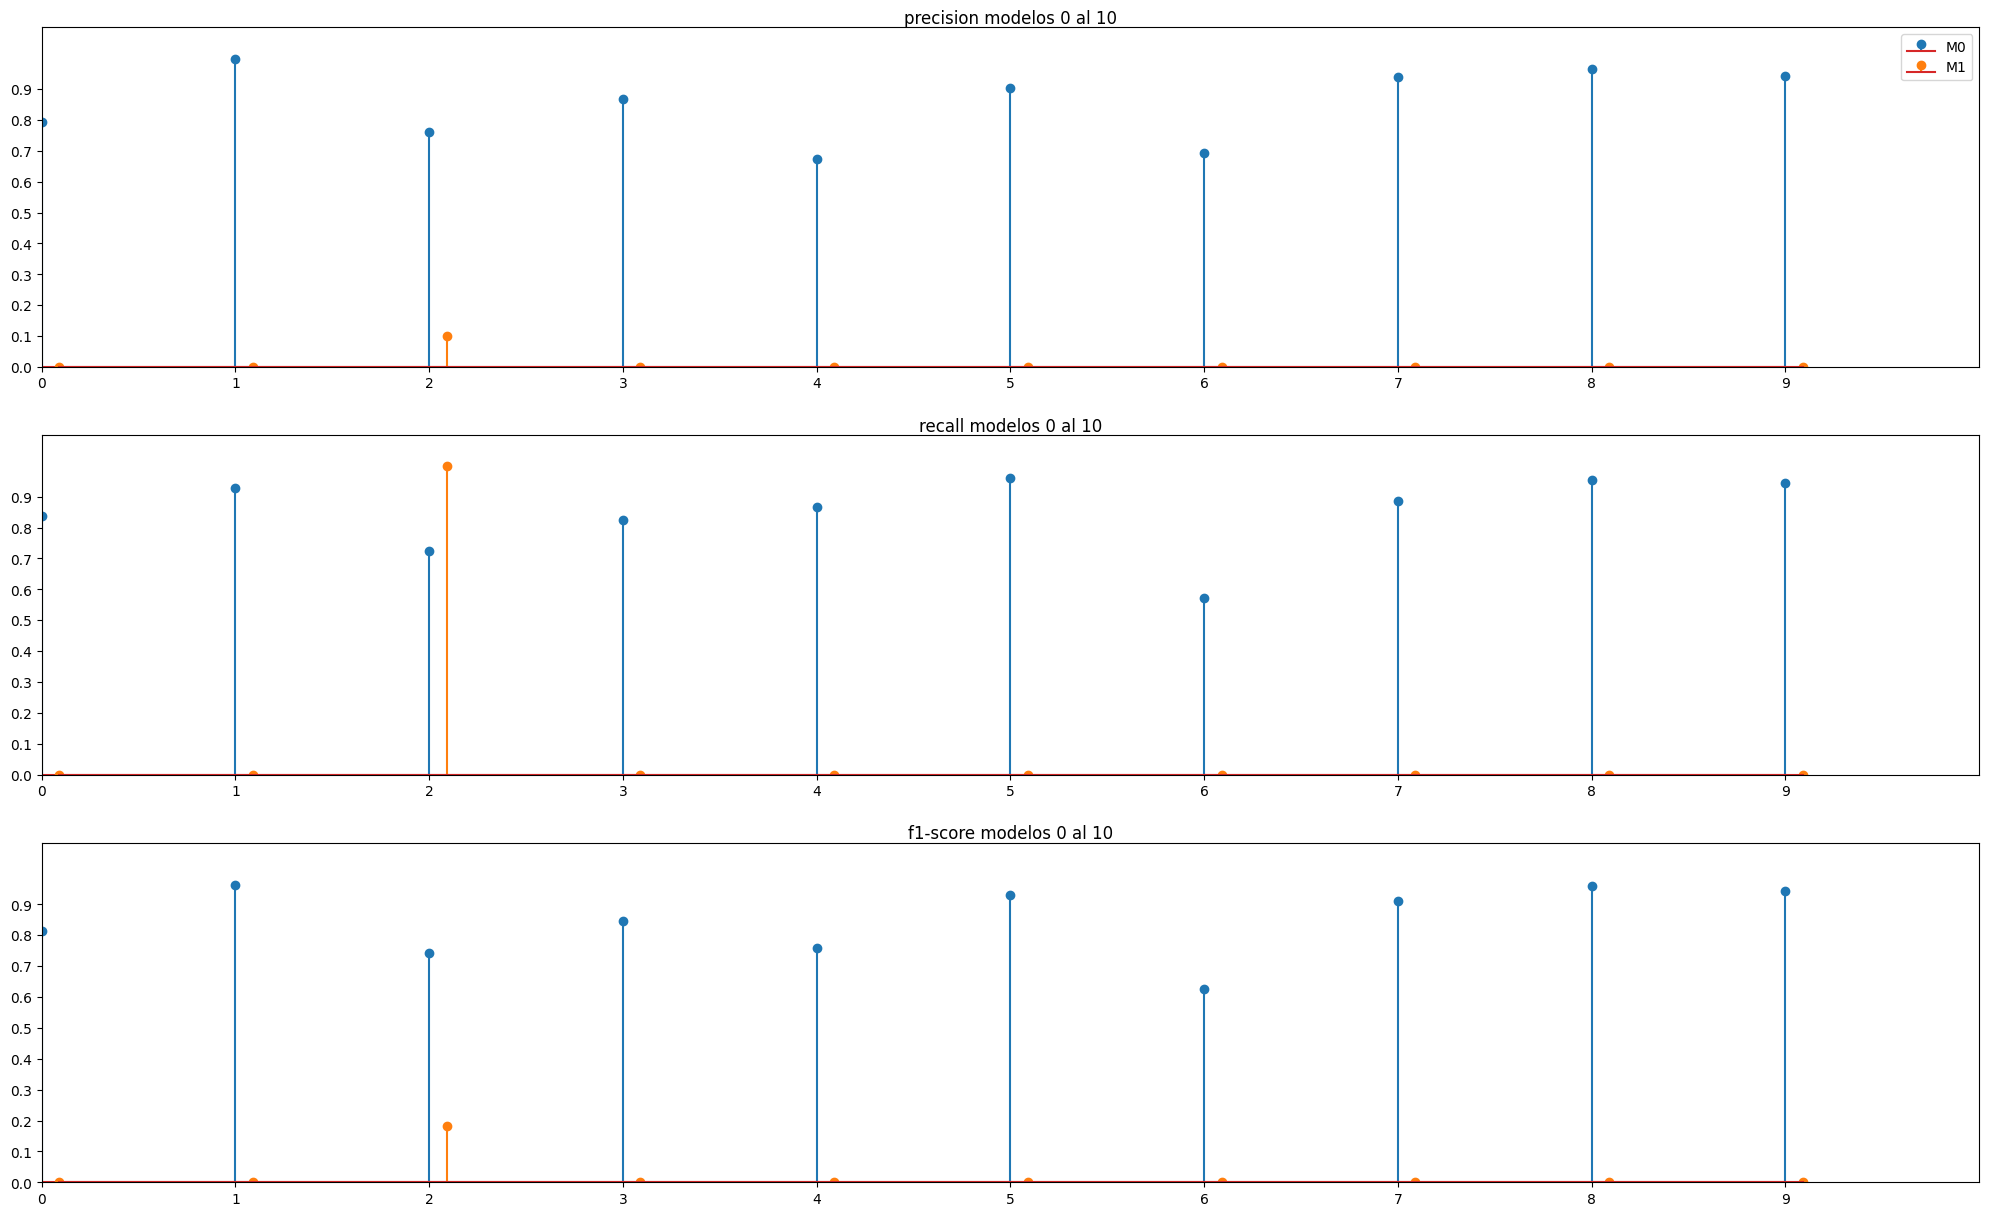

In [15]:
layer_density_list = [256,256,128,64]
n_layers = 4
model_results_tuple = new_model_softmax(optimizador,kernreg,kerninit,nlayers=n_layers,layer_act=layer_act_list, layer_density=layer_density_list, )
results_vector.append(model_results_tuple)
plot_compare(results_vector)
plot_class_reports(results_vector)


Notamos que agregar una capa mas, si bien agrega muchos parametros, claramente no significa que el modelo pueda ajustarse mejor (vemos resultados muy malos de este ultimo modelo)

##Modelo 2


Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal
Epoch 1/200
1310/1313 [============================>.] - ETA: 0s - loss: 0.9536 - accuracy: 0.6880
Epoch 1: val_accuracy improved from -inf to 0.77333, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal.h5
1313/1313 [==============================] - 7s 4ms/step - loss: 0.9530 - accuracy: 0.6881 - val_loss: 0.6703 - val_accuracy: 0.7733
Epoch 2/200
1304/1313 [============================>.] - ETA: 0s - loss: 0.6190 - accuracy: 0.7778
Epoch 2: val_accuracy improved from 0.77333 to 0.80283, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal.h5
1313/1313 [==============================] - 6s 5ms/step - loss: 0.6184 - accuracy: 0.7782 - val_loss: 0.5384 - val_accuracy: 0.8028
Epoch 3/200
1307/1313 [============================>.] - ETA: 0s - loss: 0.5475 - accuracy: 0.8012
Epoch 3: val_accuracy did not improve from 0.80283
1313/1313 [

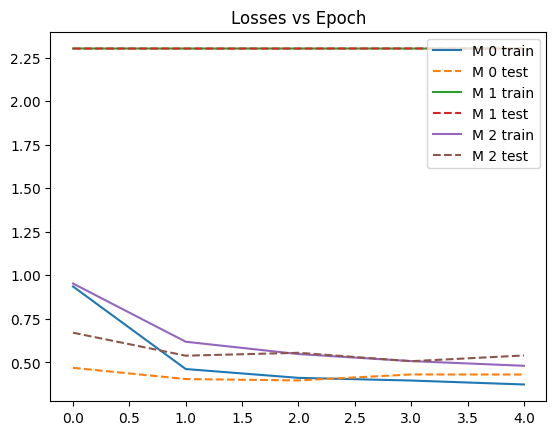

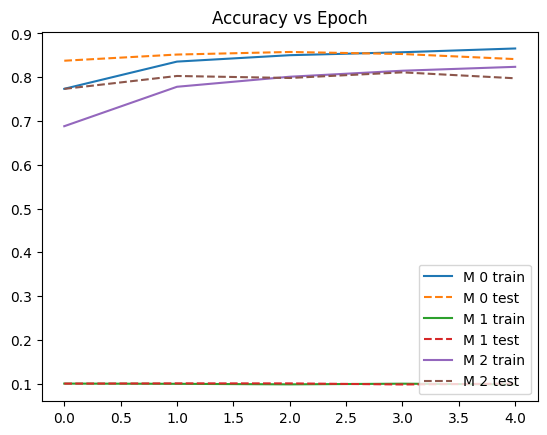

3


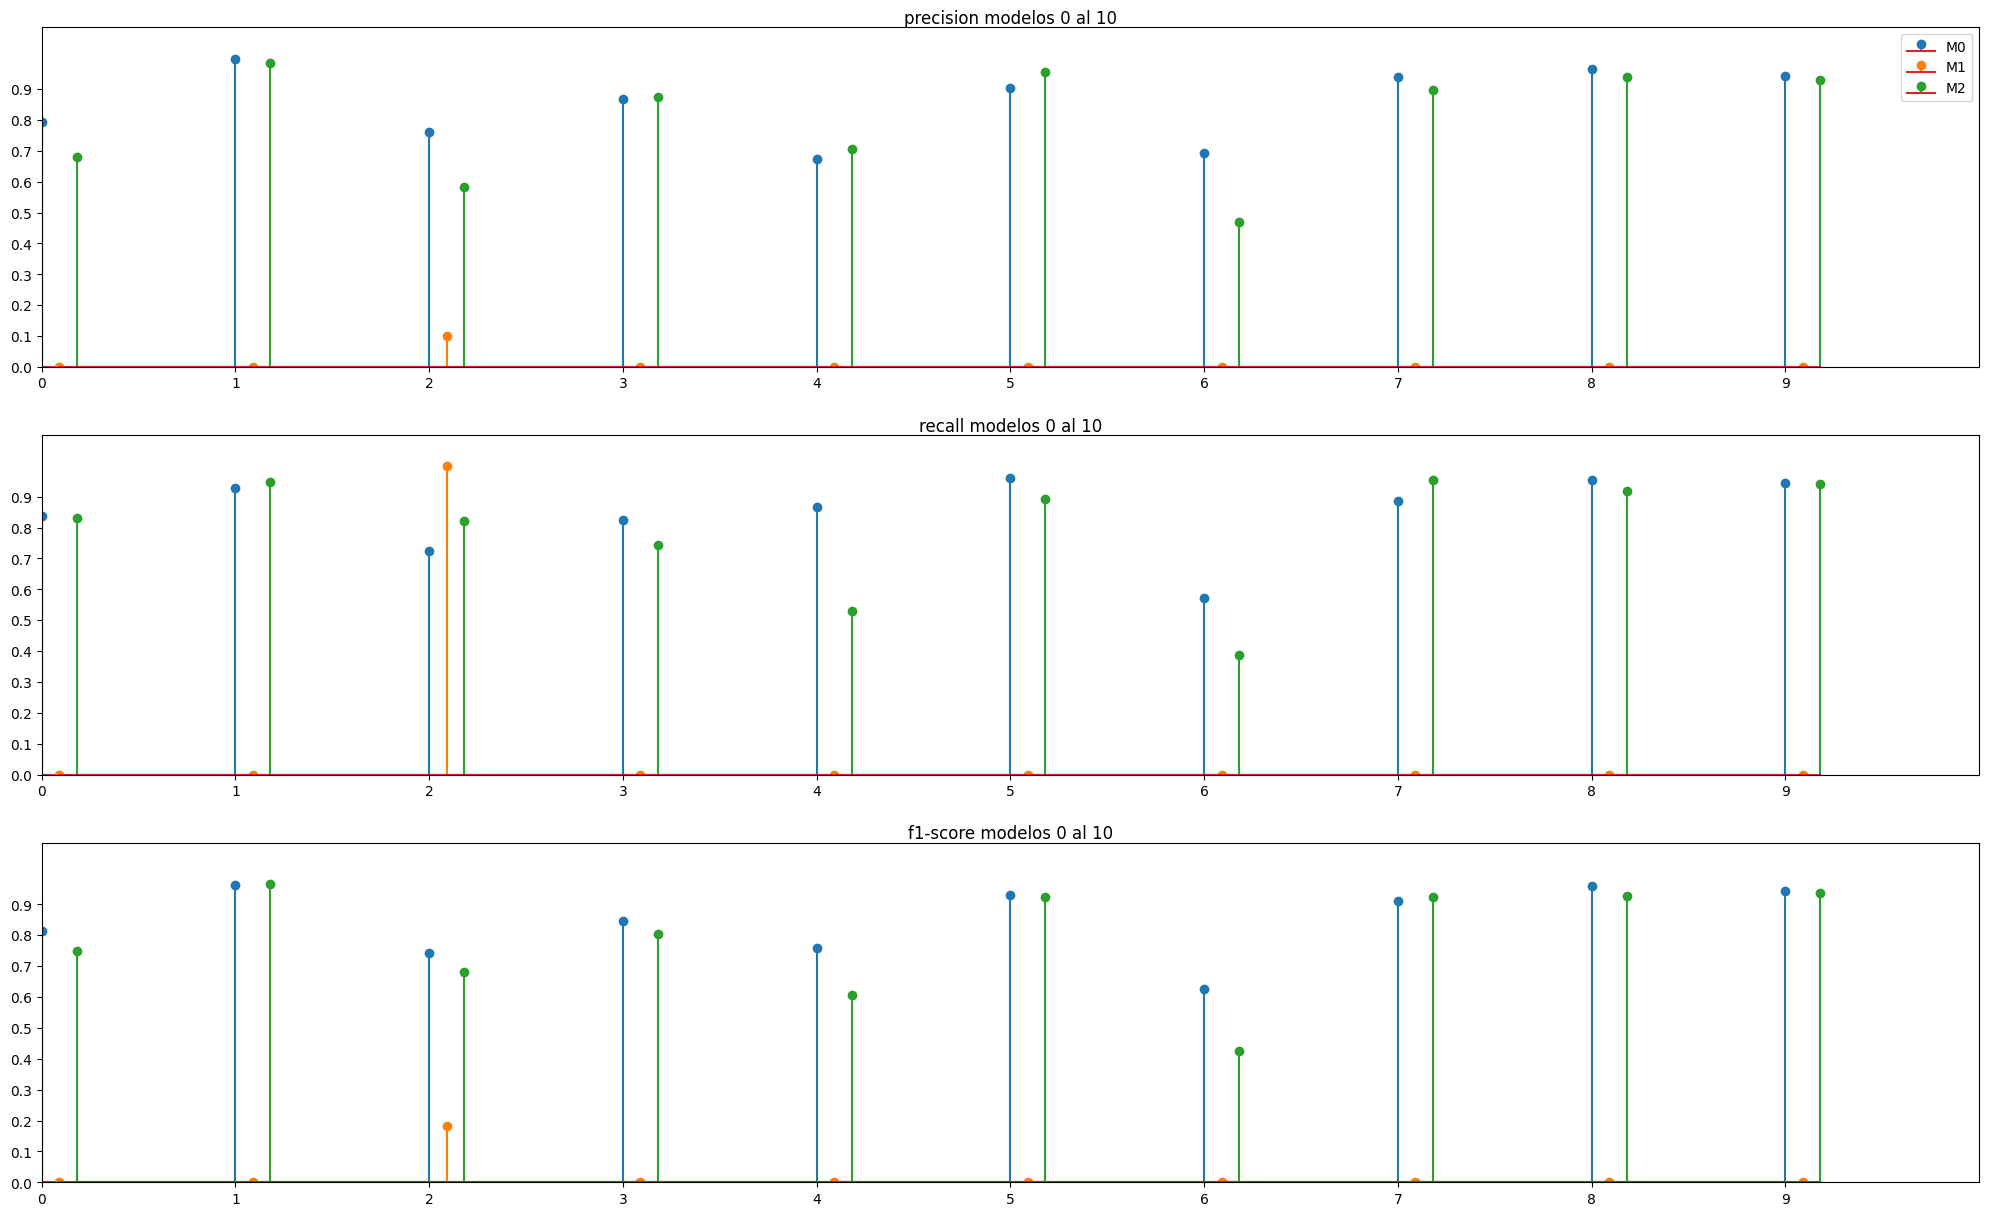

In [16]:
layer_density_list = [16,32,128]
n_layers = 3
model_results_tuple = new_model_softmax(optimizador,kernreg,kerninit,nlayers=n_layers,layer_act=layer_act_list, layer_density=layer_density_list, )
results_vector.append(model_results_tuple)
plot_compare(results_vector)
plot_class_reports(results_vector)

Podemos

##Modelo 3

Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal
Epoch 1/200
1307/1313 [============================>.] - ETA: 0s - loss: 0.9955 - accuracy: 0.6398
Epoch 1: val_accuracy improved from -inf to 0.77594, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal.h5
1313/1313 [==============================] - 13s 7ms/step - loss: 0.9950 - accuracy: 0.6401 - val_loss: 0.5962 - val_accuracy: 0.7759
Epoch 2/200
1312/1313 [============================>.] - ETA: 0s - loss: 0.7831 - accuracy: 0.7143
Epoch 2: val_accuracy improved from 0.77594 to 0.81028, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal.h5
1313/1313 [==============================] - 9s 7ms/step - loss: 0.7831 - accuracy: 0.7143 - val_loss: 0.5466 - val_accuracy: 0.8103
Epoch 3/200
1313/1313 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.7350
Epoch 3: val_accuracy improved from 0.81028 to 0.82306, savin

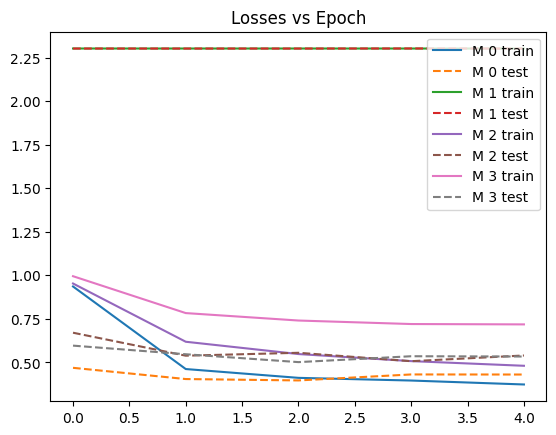

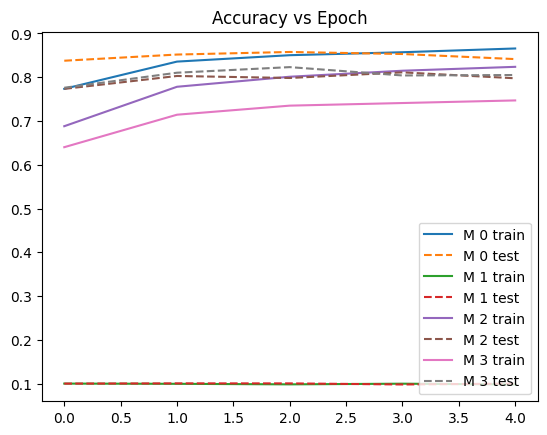

4


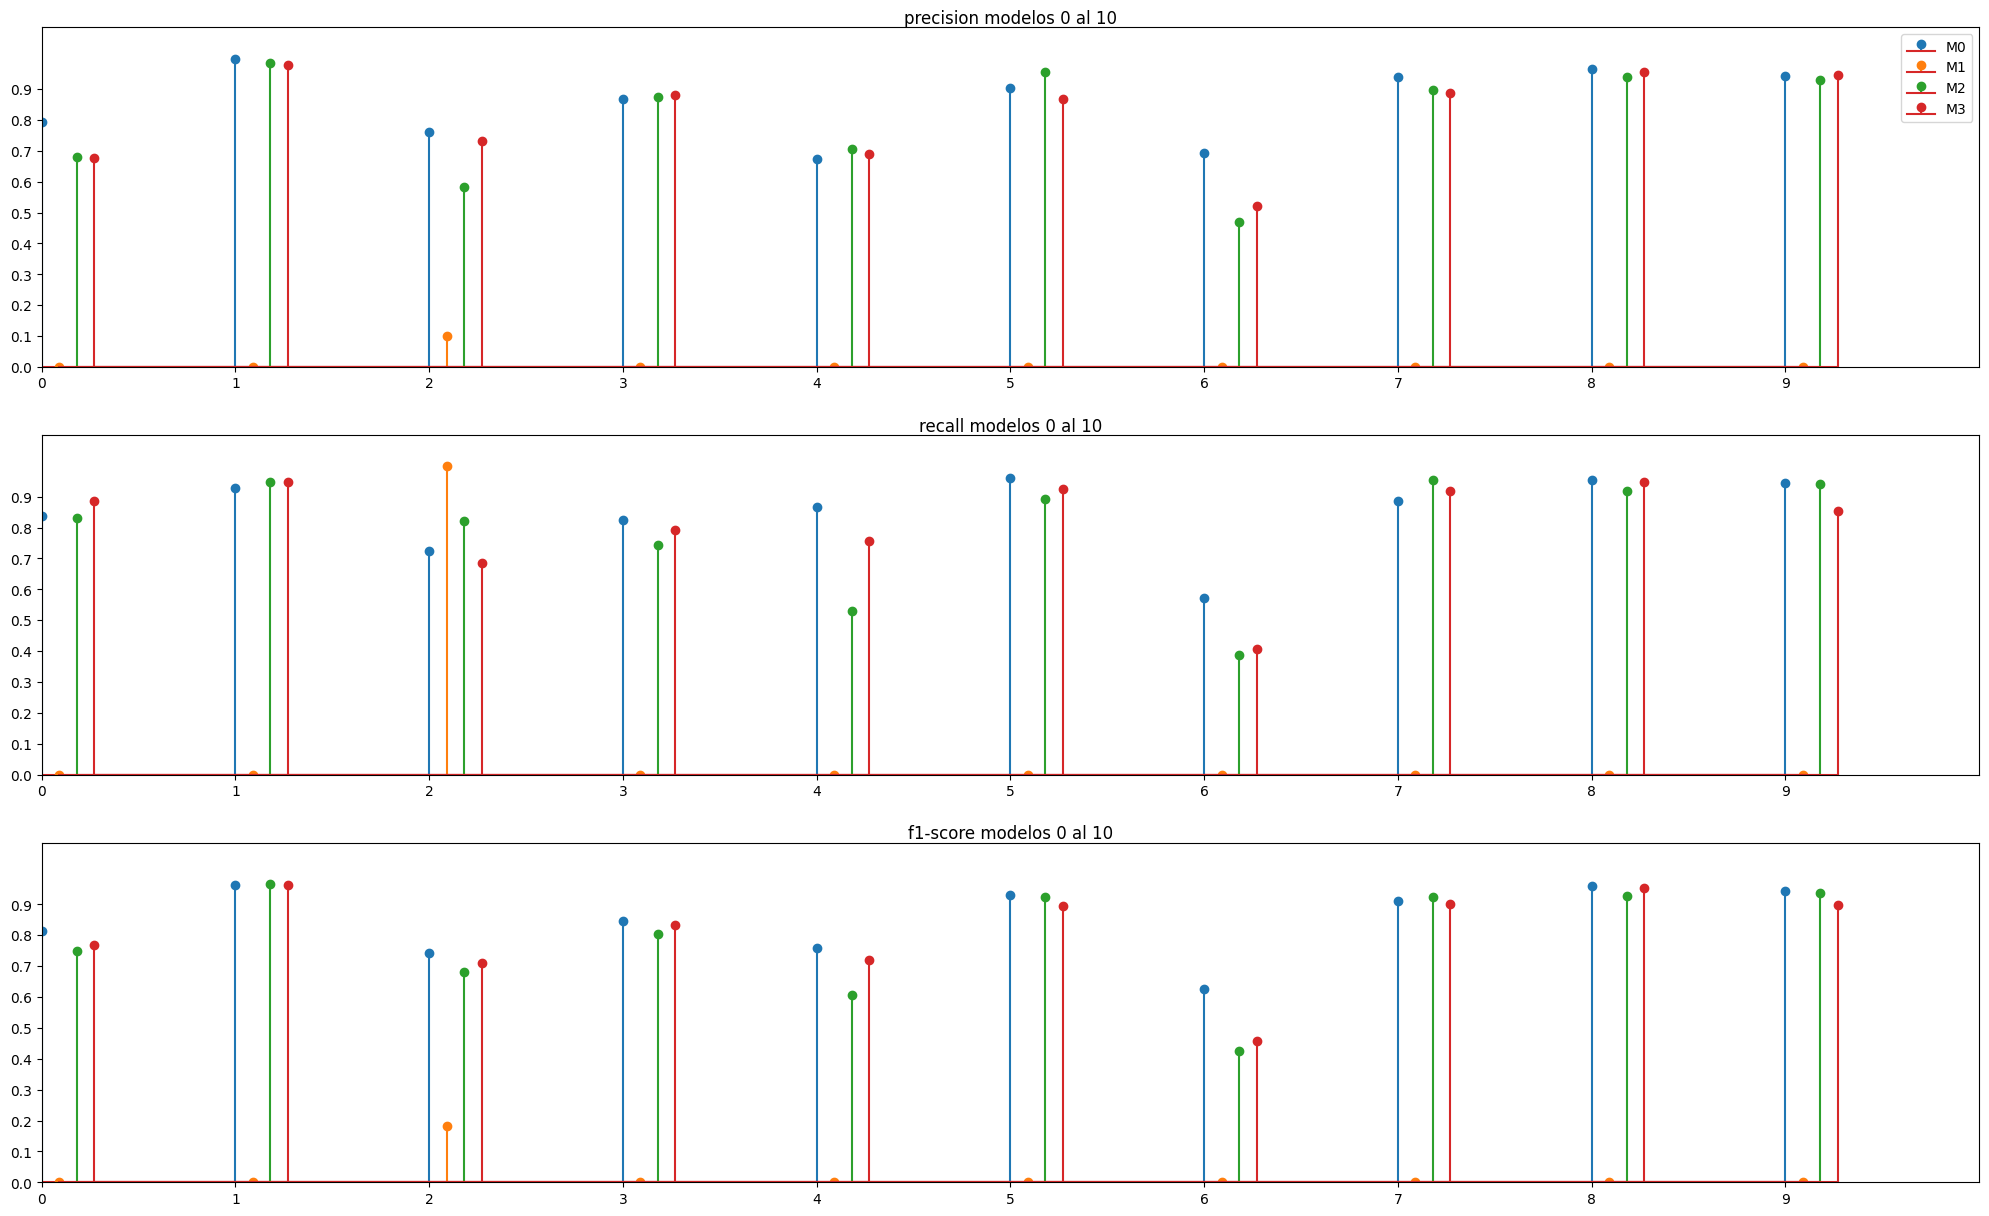

In [17]:
layer_density_list = [16,32,128]
n_layers = 3
model_results_tuple = new_model_softmax(optimizador,kernreg,kerninit,nlayers=n_layers,layer_act=layer_act_list, layer_density=layer_density_list,dpout_layer=0.20,batch_normalization=True )
results_vector.append(model_results_tuple)
plot_compare(results_vector)
plot_class_reports(results_vector)

##Modelo 4

Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal
Epoch 1/200
1303/1313 [============================>.] - ETA: 0s - loss: 1.0839 - accuracy: 0.7922
Epoch 1: val_accuracy improved from -inf to 0.82017, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal.h5
1313/1313 [==============================] - 7s 4ms/step - loss: 1.0795 - accuracy: 0.7925 - val_loss: 0.4882 - val_accuracy: 0.8202
Epoch 2/200
1310/1313 [============================>.] - ETA: 0s - loss: 0.4326 - accuracy: 0.8442
Epoch 2: val_accuracy improved from 0.82017 to 0.83978, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal.h5
1313/1313 [==============================] - 6s 5ms/step - loss: 0.4332 - accuracy: 0.8441 - val_loss: 0.4782 - val_accuracy: 0.8398
Epoch 3/200
1306/1313 [============================>.] - ETA: 0s - loss: 0.4091 - accuracy: 0.8525
Epoch 3: val_accuracy improved from 0.83978 to 0.85628, saving

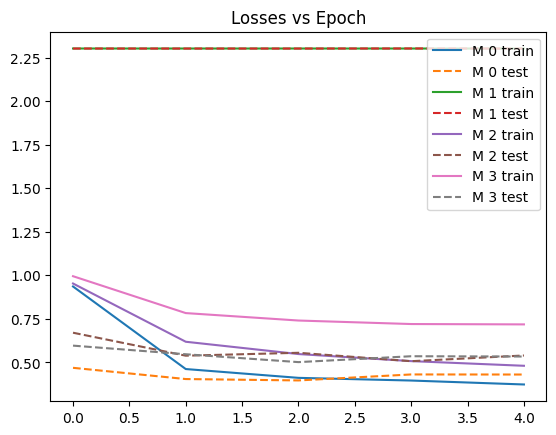

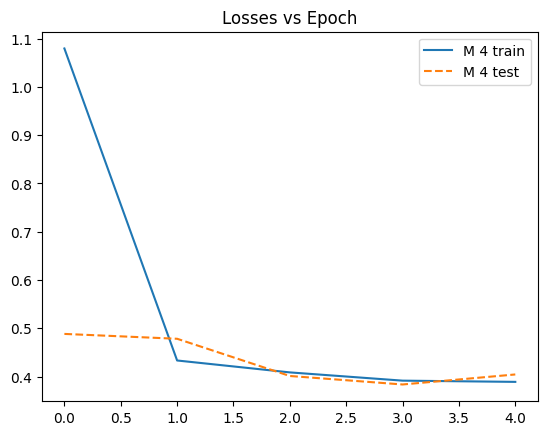

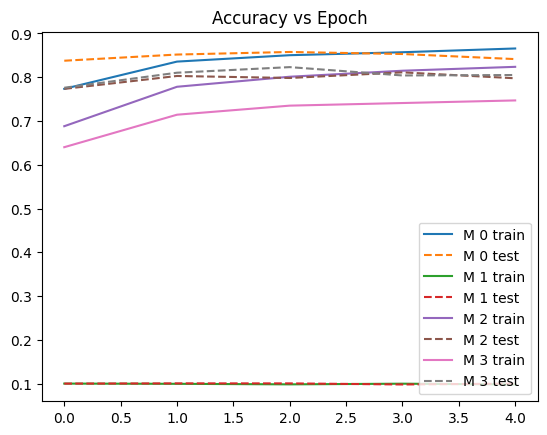

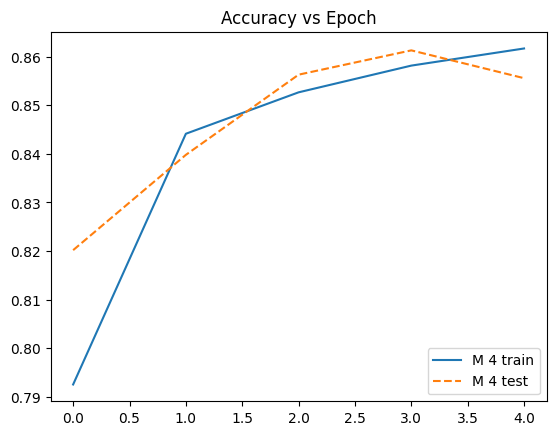

5


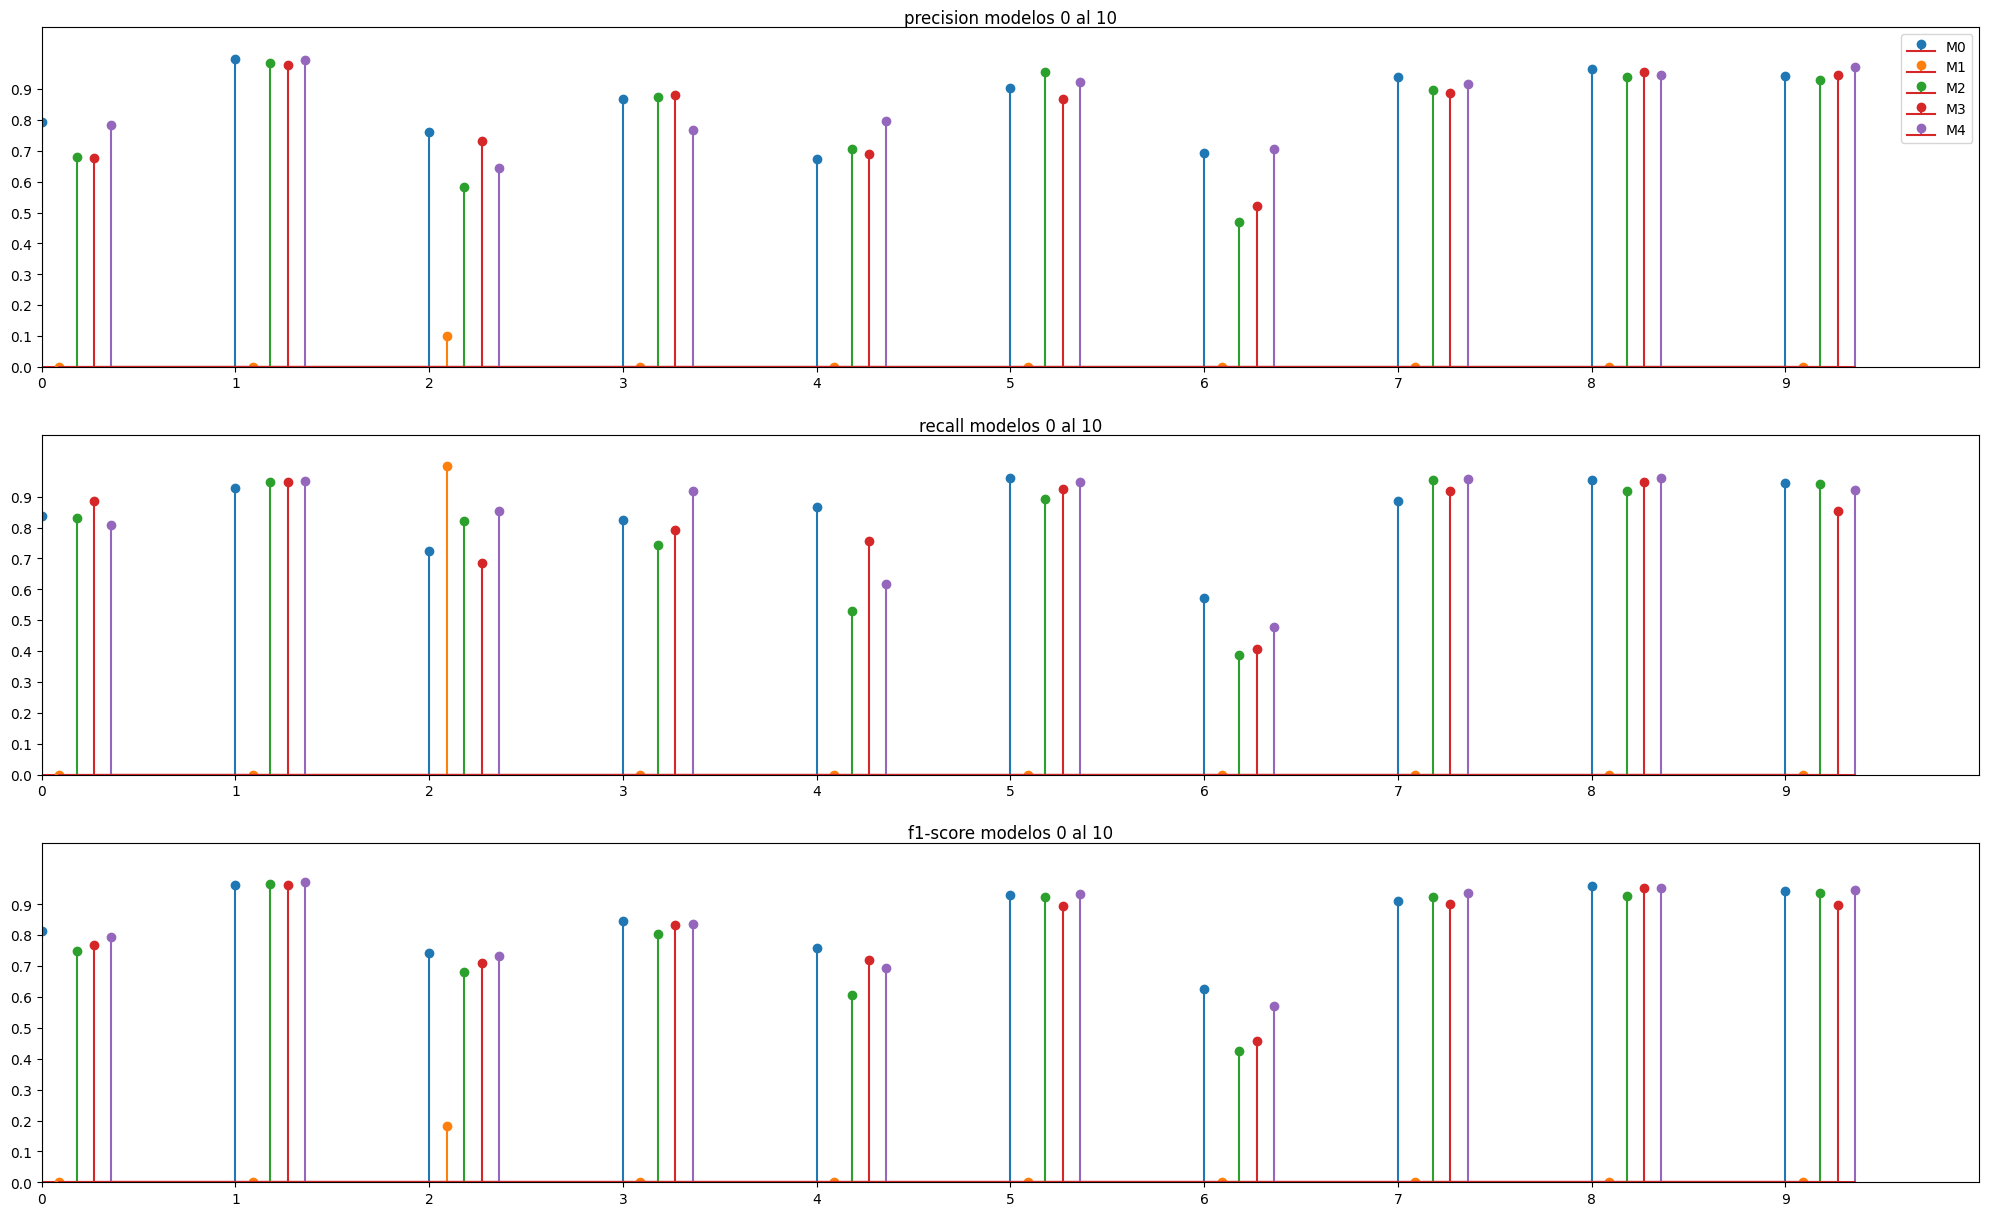

In [18]:
layer_density_list = [1024,256,64]
n_layers = 3
model_results_tuple = new_model_softmax(optimizador,kernreg,kerninit,nlayers=n_layers,layer_act=layer_act_list, layer_density=layer_density_list )
results_vector.append(model_results_tuple)
plot_compare(results_vector)
plot_class_reports(results_vector)

In [19]:
print_best_models(results_vector)

El modelo con mejor accuracy de train es el: M 0  ( Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal ) ----> Acc: 0.8656428456306458
El modelo con mejor accuracy de validacion es el: M 4  ( Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal ) ----> ValAcc: 0.8612777590751648
El modelo con mejor loss de train es el: M 0 ( Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal ) ----> Loss: 0.9359357357025146
El modelo con mejor loss de validacion es el: M 0 ( Modelo con optimizacion Adam, Regularizacion kernel l1_l2 y kerninit normal ) ----> ValLoss: 0.46863991022109985


Algunas metricas significativas de nuestro modelo:

In [ ]:

  #plot_class_reports(results_vector)}

  plot_compare(results_vector,6)
  plot_class_reports(results_vector)

In [ ]:

print_best_models(results_vector)
plot_compare(results_vector, models_perfig=4)